# **Logistic Regression from Scratch (NumPy) - Day 2**

**Plan:**

Create a simple 2D binary dataset

Implement logistic regression (sigmoid, loss, gradient descent) with NumPy

Visualize decision boundary

Compare to scikit-learn

In [2]:
import numpy as np
from numpy.random import default_rng

# RNG for reproducibility
rng = default_rng(42)


In [3]:
import os, sys, math
import numpy as np
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0], "| NumPy:", np.__version__)
rng = np.random.default_rng(7)
os.makedirs("../figures", exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (5, 4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})


Python: 3.13.7 | NumPy: 2.3.2


**Generate a toy dataset**

Two Gaussian blobs in 2D; split into train/test; standardize features.

In [4]:
# Data: two classes in 2D
n_per = 150
cov = [[1.2, 0.2],[0.2, 1.0]]
X0 = rng.multivariate_normal(mean=[-2, -1], cov=cov, size=n_per)
X1 = rng.multivariate_normal(mean=[+2, +1], cov=cov, size=n_per)
X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n_per), np.ones(n_per)])

# Train/test split (80/20)
idx = rng.permutation(len(X))
train_n = int(0.8*len(X))
tr, te = idx[:train_n], idx[train_n:]
X_train, y_train = X[tr], y[tr]
X_test, y_test = X[te], y[te]

# Standardize using train stats
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)
X_train_std = (X_train - mu) / sigma
X_test_std  = (X_test  - mu) / sigma

# Add bias term (x0=1)
def add_bias(Z):
    return np.hstack([np.ones((Z.shape[0],1)), Z])

Xb_train = add_bias(X_train_std)
Xb_test  = add_bias(X_test_std)


**NumPy logistic regression**

We’ll implement: sigmoid, negative log-loss, and gradient descent to learn weights.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba(W, Xb):
    return sigmoid(Xb @ W)

def loss_nll(W, Xb, y):
    p = predict_proba(W, Xb)
    eps = 1e-12
    p = np.clip(p, eps, 1-eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def grad(W, Xb, y):
    p = predict_proba(W, Xb)
    return (Xb.T @ (p - y)) / len(y)

# Train with gradient descent
W = np.zeros(Xb_train.shape[1])
lr = 0.1
epochs = 1000

losses = []
for t in range(epochs):
    g = grad(W, Xb_train, y_train)
    W -= lr * g
    if t % 50 == 0 or t == epochs-1:
        losses.append(loss_nll(W, Xb_train, y_train))

print("Final train loss:", loss_nll(W, Xb_train, y_train))

# Accuracy
p_test = predict_proba(W, Xb_test)
yhat = (p_test >= 0.5).astype(int)
acc = (yhat == y_test).mean()
print(f"Test accuracy (NumPy): {acc:.3f}")


Final train loss: 0.08802276157665971
Test accuracy (NumPy): 1.000


**Decision boundary visualization**

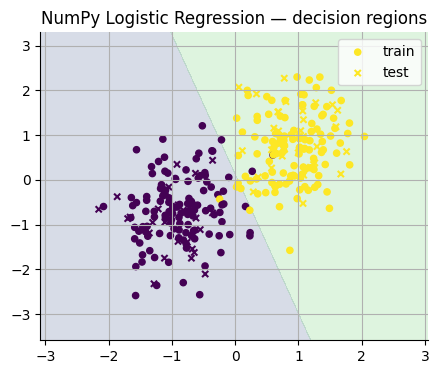

In [6]:
# Meshgrid in standardized space
x1 = np.linspace(X_train_std[:,0].min()-1, X_train_std[:,0].max()+1, 200)
x2 = np.linspace(X_train_std[:,1].min()-1, X_train_std[:,1].max()+1, 200)
xx, yy = np.meshgrid(x1, x2)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_b = np.hstack([np.ones((grid.shape[0],1)), grid])
pp = predict_proba(W, grid_b).reshape(xx.shape)

fig, ax = plt.subplots()
cs = ax.contourf(xx, yy, pp, levels=[0,0.5,1], alpha=0.2)
ax.scatter(X_train_std[:,0], X_train_std[:,1], c=y_train, s=20, label="train")
ax.scatter(X_test_std[:,0], X_test_std[:,1], c=y_test, s=20, marker="x", label="test")
ax.set_title("NumPy Logistic Regression — decision regions")
ax.legend()
plt.show()

fig.savefig("../figures/day2_logreg_numpy_boundary.png", dpi=150, bbox_inches="tight")


**Compare with scikit-learn**

In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train_std, y_train)
sk_acc = clf.score(X_test_std, y_test)
print(f"Test accuracy (scikit-learn): {sk_acc:.3f}")


Test accuracy (scikit-learn): 1.000


In [8]:
import numpy as np
# TODO: implement sigmoid, loss, gradient descent